# PapuGaPT2

In [1]:
from transformers import TextDataset, AutoTokenizer, AutoModelForCausalLM, \
pipeline, set_seed, Trainer, AdamW, get_linear_schedule_with_warmup, GPT2Config, \
GPT2LMHeadModel

import datasets
import time
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from datetime import datetime
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [2]:
path_to_file = "data/songs_data.txt"
BATCH_SIZE = 2
RANDOM_SEED = 123
MAX_LEN = 1024
EPOCHS = 2

In [3]:
model = AutoModelForCausalLM.from_pretrained('flax-community/papuGaPT2')
tokenizer = AutoTokenizer.from_pretrained('flax-community/papuGaPT2')
special_tokens_dict = {
     'bos_token': '<BOS>', 
     'eos_token': '<EOS>', 
     'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Added {num_added_tokens} new tokes.")

set_seed(RANDOM_SEED) # reproducibility
torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Added 3 new tokes.


number of songs = 7562


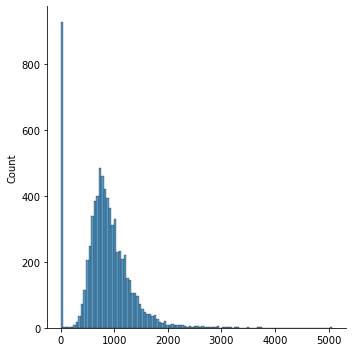

number of songs afer removing 0s = 6634


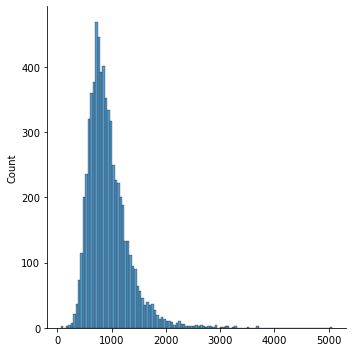

In [4]:
songs = []
with open("data/songs_data.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    song = ""
    for line in lines:
        if line == "\n":
            songs.append(song)
            song = ""
        else:
            song += line
            song += " "
songs.append(song)
print(f"number of songs = {len(songs)}")

ls = [len(i) for i in songs]
#fig, ax = plt.subplots(1, 1, figsize=(4,4))
sn.displot(ls)
plt.show()

old_songs = songs.copy()
songs = []
for i in old_songs:
    if len(i)>0:
        songs.append(i)
        
print(f"number of songs afer removing 0s = {len(songs)}")
ls = [len(i) for i in songs]
sn.displot(ls)
plt.show()

In [5]:
class DiscoDataset(Dataset):
    def __init__(self, data, tokenizer, gpt2_type='gpt2', max_length=MAX_LEN):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        for i in data:
            encodings_dict = tokenizer(i,'<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length')

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
        
songs_dataset = DiscoDataset(songs, tokenizer, max_length=MAX_LEN)

songs_dataset_train_dataloader = DataLoader(songs_dataset,
                              sampler=RandomSampler(songs_dataset),
                              batch_size=BATCH_SIZE)

In [6]:
# helper function for logging time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50

# create text generation seed prompt
# device = torch.device('cuda')

prompt = "<BOS>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
#generated = generated.to(device)

In [7]:
model.resize_token_embeddings(len(tokenizer))

#poem_stanza_model.cuda()
#model = GPT2LMHeadModel.from_pretrained('flax-community/papuGaPT2', config=configuration)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)

total_steps = len(songs_dataset_train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

start_time = time.time()
total_steps_epoch = total_steps // EPOCHS
# poem_stanza_model = poem_stanza_model.to(device)

for epoch_i in range(0, EPOCHS):

    print(f'Epoch {epoch_i + 1} of {EPOCHS}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(songs_dataset_train_dataloader):
        
        if step % 10 == 0:
            curr_time = datetime.now().strftime("%H:%M:%S")
            print(f"Step {step} out of {total_steps_epoch} steps ({curr_time}, epoch = {epoch_i}).")
        
        b_input_ids = batch[0]#.to(device)
        b_labels = batch[0]#.to(device)
        b_masks = batch[1]#.to(device)

        model.zero_grad()        
        
        #print(b_input_ids.shape)
        #print(b_input_ids[0])
        #print(b_masks.shape)
        
        outputs = model(b_input_ids,
                                    labels=b_labels,
                                    attention_mask=b_masks,
                                    token_type_ids=None)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(songs_dataset_train_dataloader)       
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch Training Time: {training_time}')

    t0 = time.time()
    
    """
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in poem_stanza_val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():        

            outputs  = model(b_input_ids,
                                         attention_mask=b_masks,
                                         labels=b_labels)

            loss = outputs[0]  

        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(poem_stanza_val_dataloader)


    print(f'Average Validation Loss: {avg_val_loss}')
    """

print(f'Total Training Time: {format_time(time.time()-start_time)}')

#torch.save(model.state_dict(), "models/PapuGaPT2_finetuned/PapuGaPT2_finetuned.pth")

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch 1 of 2
Step 1 out of 6634 total steps (09:25:55).
Step 11 out of 6634 total steps (09:31:53).
Step 21 out of 6634 total steps (09:39:02).
Step 31 out of 6634 total steps (09:51:13).
Step 41 out of 6634 total steps (10:03:54).
Step 51 out of 6634 total steps (10:10:34).
Step 61 out of 6634 total steps (10:13:36).
Step 71 out of 6634 total steps (10:16:42).
Step 81 out of 6634 total steps (10:20:24).
Step 91 out of 6634 total steps (10:23:29).
Step 101 out of 6634 total steps (10:26:30).
Step 111 out of 6634 total steps (10:29:31).
Step 121 out of 6634 total steps (10:32:32).
Step 131 out of 6634 total steps (10:35:35).
Step 141 out of 6634 total steps (10:38:36).
Step 151 out of 6634 total steps (10:41:36).
Step 161 out of 6634 total steps (10:44:36).
Step 171 out of 6634 total steps (10:47:36).
Step 181 out of 6634 total steps (10:50:34).
Step 191 out of 6634 total steps (10:53:34).
Step 201 out of 6634 total steps (10:56:34).
Step 211 out of 6634 total steps (10:59:35).
Step 221

KeyboardInterrupt: 

In [ ]:
#dataset = datasets.load_dataset("text", data_files=path_to_file)

In [ ]:
#dataset

In [ ]:
# train_data = dataset.map(
#     lambda example: tokenizer(example['text'], padding=True, truncation=True, max_length=512),#, return_tensors="pt"
#     batched=True,
#     batch_size=16
# )
# train_data = train_data.remove_columns(["text"])
# train_data.set_format("torch")

In [ ]:
#model.resize_token_embeddings(len(tokenizer))

In [ ]:
#model.resize_token_embeddings(len(tokenizer))

In [ ]:
# from transformers import DataCollatorForTokenClassification
# data_collator = DataCollatorForTokenClassification(tokenizer)


# trainer = Trainer(
#     model=model,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     #args=TrainingArguments(output_dir="/content/drive/MyDrive/NLP/model"),
#     train_dataset=train_data["train"]
# )
# trainer.train()